# 18460 Project

In [1]:
%load_ext autoreload
%autoreload 2

from tasks import *
import numpy as np
from server import Server

First, we initialize the task for a given configuration

In [2]:
#task = lrt.LinearRegressionTask(lrt.solo_config) # Linear regression
task = ct.CircleTask(ct.solo_config) # Circle

Intializing task CircleTask with config Config(clients=1, number=200, optimizer=array([10, 10,  5]))


Seeing the data

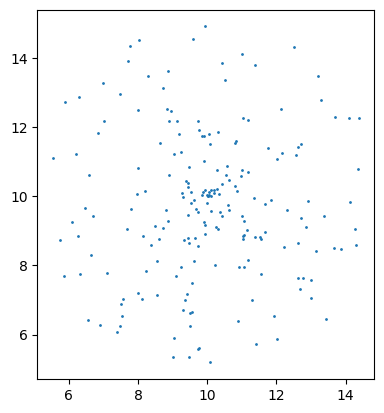

In [3]:
task.visualize()

Then, we define our optimization problem

In [4]:
problem = task.get_problem()
partitions = task.get_partitions()

Solve iteratively using federated learning

In [5]:
# Create server and initialize clients, before iteratively updating the consensus variables
server = Server(problem)
server.connect_clients(partitions) # add parameters and communicate datasets

k = 0
last_cost = float('infinity')
while k < problem.max_iter and server.delta > problem.tol:
    consensus = server.consensus.flatten()
    
    current_cost = problem.loss(consensus, task.dataset, problem.hyper_parameters)
    
    if k % 500 == 0:
        print(f'''
        Iteration {k}: {consensus}
        Cost: {current_cost}

        ''')
    
    # perform new iteration
    server.run_iteration(k+1)
    
    if np.linalg.norm(current_cost - last_cost) < problem.ctol:
        print(f"Condition reached: change in cost is {np.linalg.norm(current_cost - last_cost)} "
              f"which is smaller than {problem.ctol}")
        last_cost = current_cost
        break
        
    last_cost = current_cost
    
    k = k + 1
    
if k >= problem.max_iter and server.delta > problem.tol:
    raise Exception("Did not converge")
    
if server.delta <= problem.tol:
    print(f"Condition reached: change in solution is {server.delta} "
          f"which is smaller than {problem.tol}")
    
solution = server.consensus.flatten()
    
print("")
print(f"Solution: {solution}")
print(f"Associated cost: {last_cost}")
print(f"Achieved in {k} iterations")


        Iteration 0: [-0.90170903 -1.69039785  1.13456141]
        Cost: 243.5320711107202

        
Condition reached: change in cost is 0.0006316855203380989 which is smaller than 0.001

Solution: [ 9.87051348 10.04825018  4.78098289]
Associated cost: 1.194666499865012
Achieved in 79 iterations


## Visualization of the solution

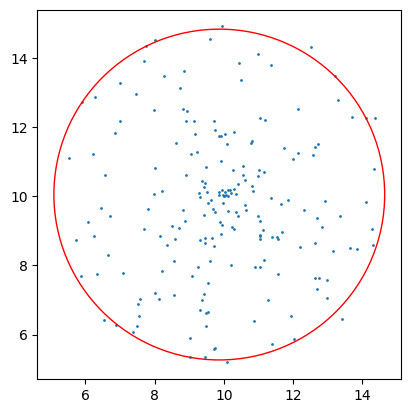

In [6]:
task.visualize_solution(solution)